In [1]:
import numpy as np
import pandas as pd
import os
import sys

# Get the current directory of the script
current_dir = os.path.dirname(os.path.abspath(''))
# Get the parent directory
parent_dir = os.path.dirname(current_dir)
parent_dir2 = os.path.dirname(parent_dir)

sys.path.append(parent_dir2)
from data_preprocessing import Data_Preprocessing

In [2]:
categorical_columns = ["Material number", "Supplier", "Contract", "Contract Position", "Procurement type", 
                                    "Special procurement type", "Dispatcher", "Buyer", "Purchasing group", 
                                    "Purchasing lot size", "Calendar", "Plant", "Plant information record", 
                                    "Information record number", "Information record type",  "Product group",
                                    "Base unit"]
numerical_columns = ["Fulfillment time", "Fixed contract 1", "Fixed contract 2", "Total quantity", "Total value", 
                                  "Price unit", "Plant processing time", "Material master time"]
        


file_path = 'sampled_data.csv'

Data=Data_Preprocessing(file_path=file_path)
data, not_processed_data= Data.preprocess_data_kmean()
print(data)

Index(['Material number', 'Supplier', 'Contract', 'Contract Position',
       'Fulfillment time', 'Fixed contract 1', 'Fixed contract 2',
       'Procurement type', 'Special procurement type', 'Dispatcher', 'Buyer',
       'Purchasing group', 'Purchasing lot size', 'Total quantity',
       'Total value', 'Price unit', 'Calendar', 'Plant',
       'Plant information record', 'Information record number',
       'Information record type', 'Plant processing time',
       'Material master time', 'Product group', 'Base unit'],
      dtype='object')
      Fulfillment time  Fixed contract 1  Fixed contract 2  Total quantity  \
0                  NaN               NaN               NaN             NaN   
1            -0.841693         -0.872359         -0.399432        0.046392   
2                  NaN               NaN               NaN       -0.096716   
3                  NaN               NaN               NaN             NaN   
4                  NaN               NaN               NaN    

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
# Encode categorical variables
#categorical_columns = data.select_dtypes(include=['object']).columns
#data[categorical_columns] = data[categorical_columns].apply(lambda col: pd.factorize(col)[0])


# Handling missing values by replacing them with the median of each column
# for col in numerical_columns:
#     if data[col].isna().any():
#         data[col].fillna(data[col].median(), inplace=True)

In [5]:
# Applying Z-score for anomaly detection in numeric columns

import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'data' is your DataFrame containing numerical features

# Calculate mean and standard deviation for each numerical column
mean_values = data[numerical_columns].mean()
std_dev_values = data[numerical_columns].std()

# Calculate Z-scores for each numerical column
z_scores = (data[numerical_columns] - mean_values) / std_dev_values

# Optionally, you can add the Z-scores as new columns to the existing DataFrame
for col in numerical_columns:
    data[f'{col}_z_score'] = z_scores[col]

In [6]:
# Create a DataFrame to store the outlier flags
outlier_flags = pd.DataFrame()

# Apply outlier detection threshold (e.g., Z-score > 3) to identify outliers
for col in numerical_columns:
    outlier_flags[col + '_outlier'] = (z_scores[col] > 3).astype(int)

# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = outlier_flags.max(axis=1)

# No need to drop outlier flags columns since they haven't been added yet
# Concatenate the anomaly label column with the input data
data = pd.concat([data, outlier_flags], axis=1)


# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = data[[col + '_outlier' for col in numerical_columns]].max(axis=1)

In [7]:
features = data.drop(columns=[col + '_z_score' for col in numerical_columns])
# Remove columns related to anomaly detection from the input data

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Assuming 'data' is your DataFrame containing numerical features and 'anomaly_label' is the binary target variable

# Split data into features and target variable
X = data.drop(columns=['anomaly_label'])
y = data['anomaly_label']

# Impute missing values with the median of each column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict anomalies on the testing data
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]  # Probability of being an outlier
y_pred = svm_model.predict(X_test)  # Binary prediction (0 or 1)

# You can now use y_pred_proba or y_pred for further analysis or evaluation
print("Prediction probabilities:", y_pred_proba)
print("Binary predictions:", y_pred)


Prediction probabilities: [5.98237772e-03 4.13156286e-03 8.31201478e-04 1.07546089e-03
 8.48970062e-04 3.75391444e-03 1.43039579e-03 9.35711967e-04
 4.49271901e-03 1.34421905e-03 7.38207435e-04 9.70560421e-04
 6.91880250e-03 4.25844486e-03 2.26413986e-03 1.06359411e-03
 1.29160659e-03 2.04971308e-02 1.15472686e-03 2.24969040e-03
 8.31516340e-04 7.36825595e-04 7.07762287e-04 7.45569286e-03
 1.03006223e-01 1.94695476e-03 3.66667785e-02 2.95667566e-03
 7.26942796e-04 4.21773451e-03 8.82430116e-04 2.07041293e-01
 8.92909118e-04 7.23242022e-04 9.89708529e-04 2.61015269e-02
 1.54538962e-02 1.08526230e-02 8.19431596e-04 1.40036764e-03
 7.47688195e-03 1.46008757e-02 1.98361572e-03 2.22015785e-03
 1.32638337e-03 1.42463647e-03 7.08305449e-03 1.65033252e-02
 2.78100616e-03 2.38004357e-03 3.13044286e-03 3.36669462e-05
 2.55474958e-03 1.23826258e-03 2.22392191e-03 2.64200808e-02
 5.24836241e-03 5.74187601e-02 5.95949147e-03 1.18277662e-03
 3.28564768e-03 2.06534076e-03 7.87236026e-04 8.71836782e-0

In [9]:
# You can now use y_pred_proba or y_pred for further analysis or evaluation


# You can now use y_pred_proba or y_pred for further analysis or evaluation

data_without_nan = data.dropna(subset=['Total quantity_z_score'])

print(data['anomaly_label'])

0       0
1       0
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: anomaly_label, Length: 3000, dtype: int32


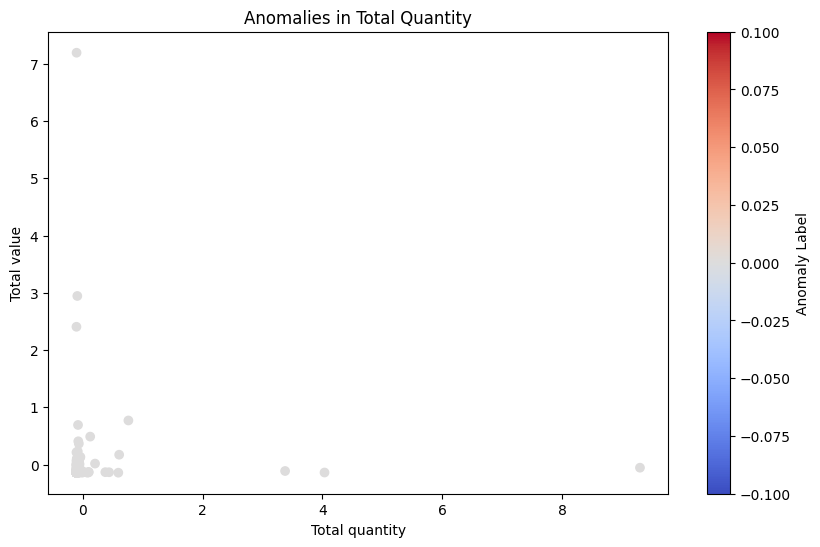

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure X_test is a DataFrame with the same columns as the original data
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Define a function to create scatter plots for anomalies
def visualize_anomalies(data, anomaly_labels):
    # Ensure that data and anomaly_labels have the same length
    assert len(data) == len(anomaly_labels), "Data and anomaly labels must have the same length."
    
    # Scatter plot for "Total quantity" and "Total value" columns
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Total quantity'], data['Total value'], c=anomaly_labels, cmap='coolwarm')
    plt.xlabel('Total quantity')
    plt.ylabel('Total value')
    plt.title('Anomalies in Total Quantity')
    plt.colorbar(label='Anomaly Label')
    plt.show()

# Predict anomalies on the testing data
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]  # Probability of being an outlier
y_pred = svm_model.predict(X_test)  # Binary prediction (0 or 1)

# Visualize anomalies in the test data
visualize_anomalies(X_test_df, y_pred)


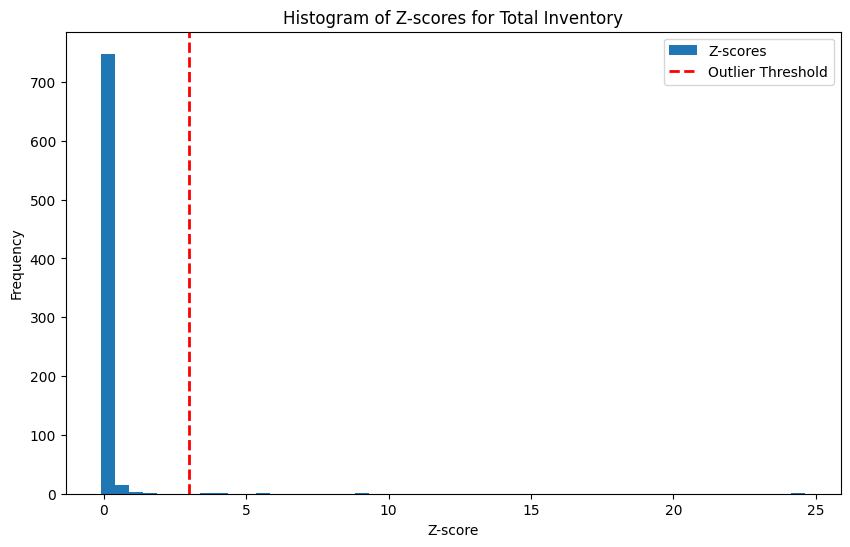

In [15]:
# Visualize statistical outliers in one of the numeric columns
plt.figure(figsize=(10, 6))
plt.hist(data_without_nan['Total quantity_z_score'],bins=50,  label='Z-scores')
plt.axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Histogram of Z-scores for Total Inventory')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
import seaborn as sns

In [ ]:
# Define a function to create scatter plots for anomalies
# def visualize_anomalies2(data, anomaly_labels):
#     # Pairplot for all numerical features
#     sns.pairplot(data, hue=da'anomaly_labels', palette={0: 'blue', 1: 'red'})
#     plt.title('Scatter Plot of Numerical Features with Anomalies')
#     plt.show()

# # Visualize anomalies
# visualize_anomalies2(data[numerical_columns], y_pred)

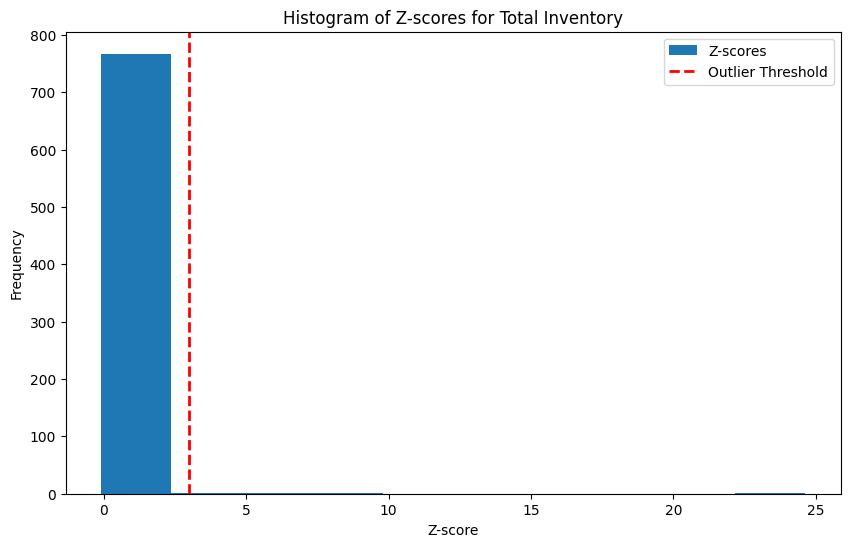

In [17]:
# Visualize statistical outliers in one of the numeric columns
plt.figure(figsize=(10, 6))
plt.hist(data_without_nan['Total quantity_z_score'],  label='Z-scores')
plt.axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Histogram of Z-scores for Total Inventory')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Find the top 5 columns with the most anomalies predicted by the SVM model
# SVM doesn't have feature importances like XGBoost, so this part will be skipped.

In [ ]:
# Plot the distributions of the top 5 most anomalous columns
# This section is not applicable for SVM directly, but you can visualize anomalies in another way.

In [18]:
# Save the updated dataset
data.to_csv('updated_with_anomalies_svm_stammdaten.csv', index=False)

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib.pyplot as plt

In [20]:
# Handling missing values by replacing them with the median of each column
for col in numerical_columns:
    if data[col].isna().any():
        data[col].fillna(data[col].median(), inplace=True)

C:\Users\jijai\AppData\Local\Temp\ipykernel_30112\626542612.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\jijai\AppData\Local\Temp\ipykernel_30112\626542612.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [21]:
# Applying Z-score for anomaly detection in numeric columns
for col in numerical_columns:
    data[col + '_z_score'] = np.abs(stats.zscore(data[col]))
    data[col + '_outlier'] = 0
    data.loc[data[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

In [22]:
# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = data[[col + '_outlier' for col in numerical_columns]].max(axis=1)

In [23]:
# Train Isolation Forest model for anomaly detection
if_model = IsolationForest(random_state=42)
if_model.fit(data[numerical_columns])

# Predict anomaly labels using Isolation Forest
data['if_anomaly'] = if_model.predict(data[numerical_columns])
data['if_anomaly'] = np.where(data['if_anomaly'] == -1, 1, 0)  # Convert -1 to 1 for anomaly, 1 to 0 for normal

In [24]:
# Find the top 5 columns with the most anomalies predicted by Isolation Forest
top_5_columns = np.argsort(np.sum(np.abs(if_model.decision_function(data[numerical_columns]))))

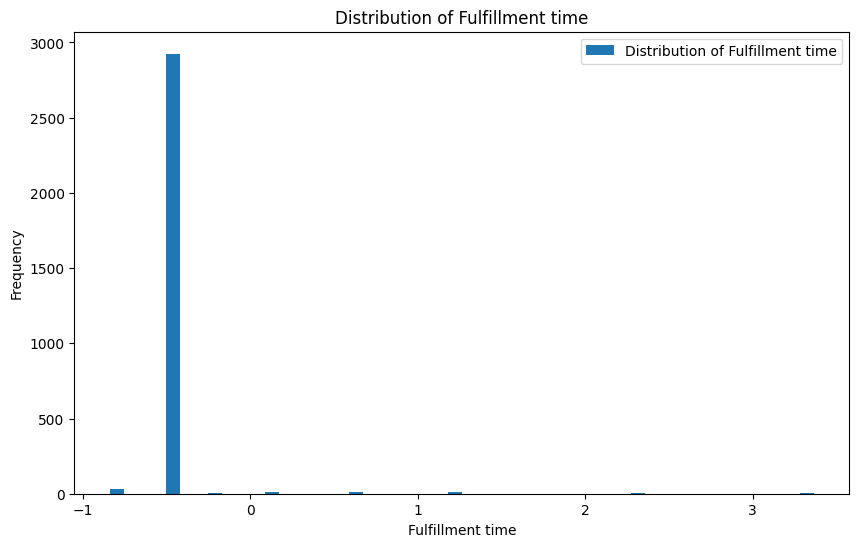

In [25]:
# Plot the distributions of the top 5 most anomalous columns
for col_index in top_5_columns[:5]:
    column_name = numerical_columns[col_index]
    plt.figure(figsize=(10, 6))
    plt.hist(data[column_name], bins=50, label=f'Distribution of {column_name}')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{column_name}_distribution.png')
    plt.show()

In [26]:
# Save the updated dataset
data.to_csv('updated_with_anomalies_iforest_stammdaten.csv', index=False)

In [27]:
# Scatter plots for detected anomalies
plt.figure(figsize=(15, 10))
for col_index in range(len(numerical_columns)):
    column_name = numerical_columns[col_index]

<Figure size 1500x1000 with 0 Axes>